In [3]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community


c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [5]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]

In [6]:
print(f'Number of nodes: {data.num_nodes}')


Number of nodes: 2708
Number of edges: 10556


In [32]:
#print all edges
data.edge_index.t().tolist()

#create a networkx graph
cora_graph = to_networkx(data, to_undirected=True)

In [36]:
#import client gml file called new_facebook_network.gml and convert to networkx graph
client_graph = nx.read_gml('new_facebook_network.gml')
#create a dictionary of each node and a list of its neighbors
client_neighbors = {}
for node in client_graph.nodes():
    client_neighbors[node] = list(client_graph.neighbors(node))
    


In [42]:
#select 100 nodes with the largest degree as nodes for each node in the client graph

#degree of each node
degree_dict = dict(cora_graph.degree(cora_graph.nodes()))
degree_dict
#sort the nodes according to their degree
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
sorted_degree

top_100_nodes = [x[0] for x in sorted_degree[:100]]
top_100_nodes

[1358,
 306,
 1701,
 1986,
 1810,
 1623,
 2034,
 88,
 1013,
 598,
 109,
 2045,
 1914,
 1072,
 1542,
 733,
 1224,
 1042,
 1169,
 1441,
 1483,
 95,
 415,
 1131,
 118,
 963,
 1413,
 1692,
 2182,
 436,
 507,
 1416,
 310,
 973,
 1103,
 1624,
 1628,
 1703,
 1765,
 2155,
 429,
 661,
 1257,
 1309,
 1725,
 2001,
 2394,
 525,
 687,
 1229,
 1742,
 1950,
 1973,
 350,
 1740,
 1894,
 2248,
 2367,
 2671,
 239,
 1015,
 1119,
 1505,
 1927,
 55,
 73,
 154,
 279,
 487,
 519,
 565,
 577,
 645,
 657,
 734,
 1655,
 1776,
 1966,
 2025,
 2130,
 2450,
 2464,
 94,
 218,
 236,
 364,
 441,
 454,
 505,
 748,
 756,
 1154,
 1317,
 2238,
 2359,
 2451,
 59,
 65,
 89,
 180]

In [49]:
client_to_subgraph = {}

client_neighbors.keys()

for i, c in enumerate(client_neighbors.keys()):
    client = c
    cora_node = top_100_nodes[i]
    
    #create empty graph
    client_to_subgraph[c] = nx.Graph()
    client_to_subgraph[c].add_node(cora_node)
    #add all neighbors of the top node to the graph
    client_to_subgraph[c].add_nodes_from(cora_graph.neighbors(cora_node))
    #add all edges connecting the top node and its neighbors
    client_to_subgraph[c].add_edges_from(cora_graph.edges(cora_node))
    #add all edges between the neighbors with double for loop
    for j in cora_graph.neighbors(cora_node):
        for k in cora_graph.neighbors(cora_node):
            if j != k:
                if(cora_graph.has_edge(j,k)):
                    client_to_subgraph[c].add_edge(j,k)
                

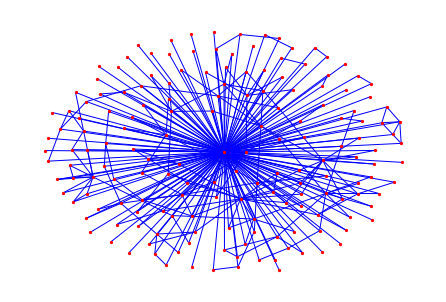

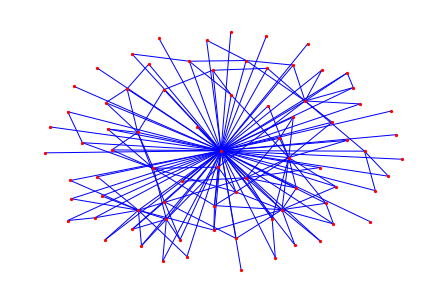

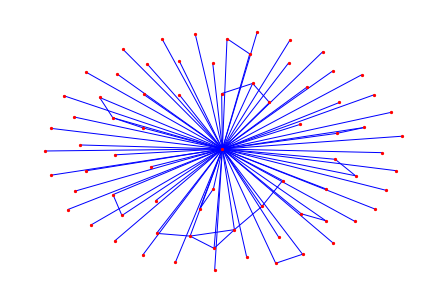

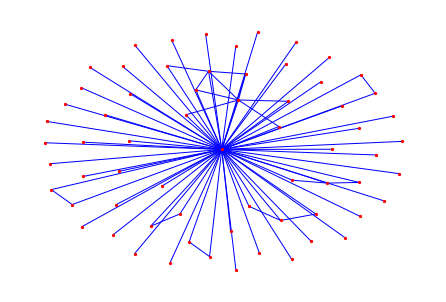

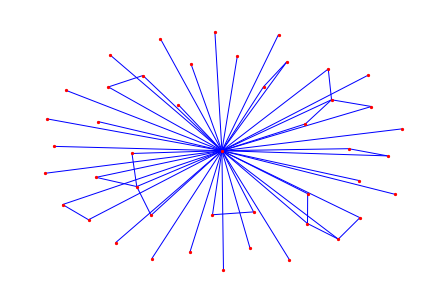

In [50]:
#draw five graphs
for i, c in enumerate(client_to_subgraph.keys()):
    nx.draw(client_to_subgraph[c], with_labels=False, node_size=5, node_color='r', edge_color='b')
    plt.show()
    if i == 4:
        break

In [67]:
#for each subgraph, calculate average degree, average path length, and degree distribution 
#degree distribution is the degree and the number of nodes with that degree
average_degree = {}
average_path_length = {}
degree_distribution = {}
number_of_nodes = {}
number_of_edges = {}

for i, c in enumerate(client_to_subgraph.keys()):
    number_of_nodes[c] = len(client_to_subgraph[c].nodes())
    number_of_edges[c] = len(client_to_subgraph[c].edges())
    average_degree[c] = sum(dict(client_to_subgraph[c].degree()).values())/len(client_to_subgraph[c].nodes())
    average_path_length[c] = nx.average_shortest_path_length(client_to_subgraph[c])
    degrees = dict(client_to_subgraph[c].degree()).values()
    degree_dict = {}
    for d in degrees:
        if d not in degree_dict:
            degree_dict[d] = 1
        else:
            degree_dict[d] += 1
    #sort dictionary by value in descending order
    sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    degree_distribution[c] = sorted_degree
    

print(average_degree)
print(average_path_length)
print(degree_distribution)
print(number_of_nodes)
print(number_of_edges)

{'828': 3.8816568047337277, '713': 4.379746835443038, '705': 2.4266666666666667, '719': 2.484848484848485, '805': 2.577777777777778, '824': 2.744186046511628, '745': 2.4390243902439024, '747': 3.4054054054054053, '823': 2.1714285714285713, '694': 2.823529411764706, '830': 3.9393939393939394, '781': 3.8181818181818183, '697': 2.8125, '724': 3.4838709677419355, '827': 3.870967741935484, '688': 2.8, '853': 3.037037037037037, '834': 2.9166666666666665, '703': 3.5833333333333335, '695': 2.5, '784': 4.521739130434782, '815': 3.4545454545454546, '752': 3.4545454545454546, '728': 3.0, '820': 2.9, '842': 3.3, '800': 5.0, '819': 3.6, '774': 2.6, '726': 2.4210526315789473, '773': 4.2105263157894735, '766': 2.210526315789474, '829': 3.7777777777777777, '780': 2.0, '810': 3.2222222222222223, '696': 2.4444444444444446, '849': 3.111111111111111, '718': 3.5555555555555554, '754': 3.3333333333333335, '760': 2.6666666666666665, '739': 2.235294117647059, '787': 2.1176470588235294, '856': 4.58823529411764

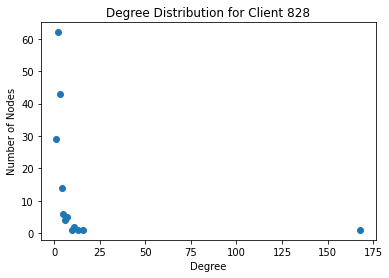

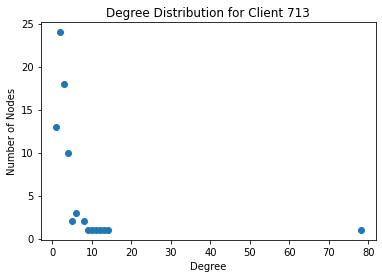

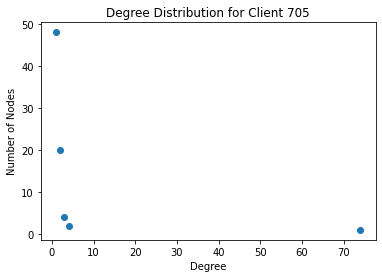

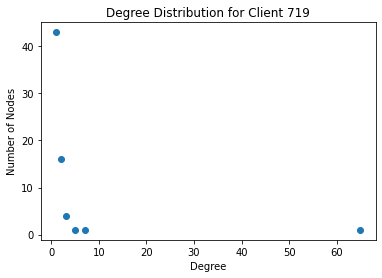

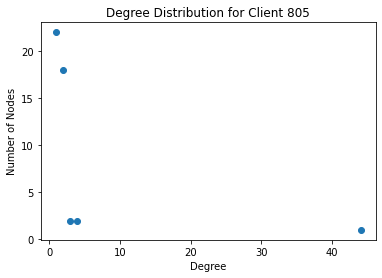

In [69]:
#plot degree distribution for 5 clients

for i, c in enumerate(client_to_subgraph.keys()):
    degrees = degree_distribution[c]
    x = [x[0] for x in degrees]
    y = [x[1] for x in degrees]
    plt.scatter(x,y)
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution for Client ' + str(c))
    plt.show()
    
    if i == 4:
        break

In [56]:
#100x100 matrix for each pair of client nodes, and the value is how many common nodes the subgraphs have

#initialize the matrix (dataframe so that we can label the rows and columns as the client nodes)
client_similarity = pd.DataFrame(index=client_neighbors.keys(), columns=client_neighbors.keys())
client_similarity = client_similarity.fillna(0)

#for each pair of client nodes, find the number of common nodes in their subgraphs
#divide by the number of nodes in the subgraph of the first client node to normalize

#go through each entry in the matrix
for i in client_similarity.index:
    for j in client_similarity.index:
        #nodes in the subgraph of the first client node
        nodes1 = client_to_subgraph[i].nodes()
        #nodes in the subgraph of the second client node
        nodes2 = client_to_subgraph[j].nodes()
        #find the number of common nodes
        common_nodes = len(set(nodes1).intersection(set(nodes2)))
        #normalize by the number of nodes in the subgraph of the first client node
        client_similarity.loc[i,j] = common_nodes/len(nodes1)
    
client_similarity

,828,713,705,719,805,824,745,747,823,694,...,722,844,768,732,736,794,693,763,765,714
828,1.000000,0.011834,0.000000,0.017751,0.000000,0.000000,0.000000,0.017751,0.005917,0.000000,...,0.0,0.047337,0.04142,0.000000,0.017751,0.005917,0.035503,0.0,0.0,0.000000
713,0.025316,1.000000,0.025316,0.025316,0.025316,0.253165,0.012658,0.000000,0.012658,0.012658,...,0.0,0.000000,0.00000,0.000000,0.000000,0.012658,0.000000,0.0,0.0,0.000000
705,0.000000,0.026667,1.000000,0.146667,0.053333,0.000000,0.026667,0.000000,0.013333,0.160000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.013333
719,0.045455,0.030303,0.166667,1.000000,0.030303,0.000000,0.015152,0.015152,0.000000,0.075758,...,0.0,0.000000,0.00000,0.015152,0.000000,0.000000,0.000000,0.0,0.0,0.015152
805,0.000000,0.044444,0.088889,0.044444,1.000000,0.022222,0.044444,0.000000,0.000000,0.088889,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.022222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000
693,0.545455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.090909,0.00000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000
763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000
765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000
